# Tutorial 1: Neural Estimation & The Importance of Critics

**Goal:** Validate Neural Mutual Information (MI) estimation in what's called the **Infinite Data Limit** (i.e., draw a fresh batch of data each iteration and set aside overfitting problems) and demonstrate how different Critic architectures affect our ability to estimate **Intrinsic Dimensionality (ID)**.

In this tutorial, we will:
1.  **Start Simple (Low Dimensional Case):** Estimate ID on a 4D Joint Gaussian dataset. We will compare Neural Estimators against an analytical baseline (CCA). Note that this regime that should work with other methods of estimating dimensionality as well.

2.  **Add Complexity (High Dimensional Case):** Embed that 4D data into a 500D space linearly and nonlinearly. We will see CCA fail if the transformation is nonlinear, while Neural Estimators hold strong in both cases. This regime is hard - and almost impossible - for other estimators, as we'll explain in later tutorials.

3.  **The Hard Case (Gaussian Mixture):** Having established the utility of Neural MI estimation in low and high dimensional cases, we use a 1D dataset but with complex geometry to demonstrate why the **Hybrid Critic** is necessary for accurate ID estimation even in low dimensions when simple dot-product critics fail.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

# Library Imports
from dim_est.run.run_dsib_single_experiment import run_dsib_infinite
from dim_est.datasets.data_generation import make_data_generator
from dim_est.utils.cca_mi_estimation import generate_CCA_mi_estimate

# Plotting Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams.update({
    "font.family": "serif", "font.serif": "Times New Roman", "mathtext.fontset": "cm",
    'figure.dpi': 100, 'font.size': 16, 'axes.titlesize': 18, 'axes.labelsize': 16,
    'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize': 14
})

# Global Constants
BATCH_SIZE = 128
# Here I'm using a larger number for better convergence, but for quicker runs, as small as 500 could work.
N_ITER = 5000 # Number of training iterations for each MI estimate
SMOOTH_WINDOW = int(0.05*N_ITER) # Last 5% for averaging and obtaining the MI estimate

## Part 0: Helper Functions

We define clean wrappers here to avoid repetitive code later. Basically a function that sweeps over different embedding dimensions using linear and nonlinear estimators, and three plotting functions.

In [ ]:
def run_neural_sweep(critic_type, label, kz_list, dataset_cfg, dataset_type="joint_gaussian"):
    """Runs the neural estimator for a list of kz values."""
    results = []
    print(f"--- Running Neural Sweep: {label} ---")
    
    for kz in tqdm(kz_list, leave=False):    
        mi_trace, _ = run_dsib_infinite(
            dataset_type=dataset_type,
            setup="infinite_data_iter",
            outfile="temp.h5", 
            dataset_overrides=dataset_cfg, 
            critic_type=critic_type,
            critic_overrides={"embed_dim": kz, "encoder_type": "mlp"},
            training_overrides={"n_iter": N_ITER, "show_progress": False, "batch_size": BATCH_SIZE}
        )
        
        # Average the last % of the trace
        smoothed = pd.Series(mi_trace).rolling(50).mean()
        final_mi = np.mean(smoothed[-SMOOTH_WINDOW:])        
        results.append({
            "Method": label,
            "kz": kz,
            "MI (Bits)": final_mi,
            "Trace": mi_trace
        })
    return results

def run_cca_sweep(dataset_cfg, kz_list, dataset_type="joint_gaussian", n_samples=N_ITER*BATCH_SIZE):
    """Runs CCA baseline for a list of kz values."""
    print(f"--- Running CCA Sweep ---")
    gen = make_data_generator(dataset_type, dataset_cfg, device='cpu')
    results = []
    
    # CCA cannot exceed the observation dimension
    obs_dim = dataset_cfg.get("transform", {}).get("observe_dim_x") 
    if obs_dim is None: # Identity case
        obs_dim = dataset_cfg["latent"]["latent_dim"]
        
    valid_kz = [k for k in kz_list if k <= obs_dim]
    
    for kz in tqdm(valid_kz, leave=False):
        mi_bits = generate_CCA_mi_estimate(
            data_generator=gen,
            ds_cfg=dataset_cfg,
            n_samples=n_samples,
            kz=kz, 
            use_cache=False,
            backend="randomized" 
        )
        results.append({
            "Method": "CCA",
            "kz": kz,
            "MI (Bits)": mi_bits,
            "Trace": None # No trace for CCA
        })
    return results

def plot_mi_saturation(results_list, title, true_id, true_mi, log_scale=False):
    """Plots MI vs kz for multiple methods."""
    df = pd.concat([pd.DataFrame(r) for r in results_list])
    
    plt.figure()
    sns.lineplot(data=df, x="kz", y="MI (Bits)", hue="Method", style="Method", markers=True, dashes=False)
    
    if true_mi is not None:
        plt.axhline(true_mi, color='black', linestyle='--', alpha=0.5, label="True MI")
    if true_id is not None:
        plt.axvline(true_id, color='red', linestyle=':', alpha=0.8, label=f"True ID = {true_id}")

    plt.title(title)
    plt.xlabel("Embedding Dimension ($k_Z$)")
    plt.ylabel("Estimated MI (Bits)")
    if log_scale:
        plt.xscale('log')
    plt.ylim(bottom=-0.1)
    plt.legend()
    plt.show()

def plot_training_traces(results, method_name):
    """Plots training curves (MI vs Iteration) for different kz."""
    plt.figure()
    # Use a color palette mapped to kz values
    unique_kz = [r['kz'] for r in results]
    palette = sns.color_palette("tab20", n_colors=len(unique_kz))
    
    for r, color in zip(results, palette):
        trace = r['Trace']
        # Smooth trace for plotting visibility
        smoothed = pd.Series(trace).rolling(50).mean()
        plt.plot(smoothed, label=f"$k_Z={r['kz']}$", color=color, linewidth=1.5)
        plt.plot(trace, color=color, alpha=0.5, linewidth=0.3)  # Faded raw trace
        
    plt.title(f"Training Traces: {method_name}")
    plt.xlabel("Iteration")
    plt.ylabel("MI Estimate (Bits)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()


def visualize_data_distribution(dataset_cfg, dataset_type="joint_gaussian", n_samples=2000, title=None, latent_dim=4):
    """
    Visualizes the raw relationship between X and Y.
    - 1D: Simple Scatter.
    - Low Dim (<=6): Component-wise subplots.
    - High Dim (>6): PCA Spectrum (Linear vs Nonlinear signature) + PC1 Correlation.
    """
    # 1. Generate Data
    gen = make_data_generator(dataset_type, dataset_cfg, device='cpu')
    x, y = gen(n_samples)
    x, y = x.numpy(), y.numpy()
    
    dim = x.shape[1]
    
    # 2. Determine Plot Type based on Dimension
    if dim == 1:
        # --- Case: 1D Mixture or Simple Gaussian ---
        plt.figure(figsize=(6, 5))
        plt.scatter(x, y, alpha=0.3, s=10)
        plt.xlabel("$X$")
        plt.ylabel("$Y$")
        plt.title(title or f"Raw Data Distribution ({dataset_type})")
        plt.show()
        
    elif dim <= 6:
        # --- Case: Low Dimensional (e.g. 4D) ---
        fig, axes = plt.subplots(1, dim, figsize=(4*dim, 4), sharex=True, sharey=True)
        if dim == 1: axes = [axes]
        
        for i, ax in enumerate(axes):
            ax.scatter(x[:, i], y[:, i], alpha=0.3, s=5)
            ax.set_title(f"Dim {i+1}")
            ax.set_xlabel(f"$X_{i+1}$")
            ax.set_ylabel(f"$Y_{i+1}$")
            
        plt.suptitle(title or f"Component-wise Correlation (Total Dims: {dim})")
        plt.tight_layout()
        plt.show()
        
    else:
        # --- Case: High Dimensional (e.g. 500D) ---
        # Strategy: Look at the specturm of the cross-covariance of X and Y
        cov_matrix = np.cov(x, y, rowvar=False)
        cov_xy = cov_matrix[:dim, dim:]  # Cross-covariance block
        singular_values = np.linalg.svd(cov_xy, compute_uv=False)
        plt.plot(range(1, len(singular_values)+1), singular_values, 'o-')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Component Index")
        plt.ylabel("Singular Value")
        plt.title(title or "Cross-Covariance Spectrum (X vs Y)")
        plt.axvline(latent_dim, color='r', linestyle='--', alpha=0.5, label=f"True ID={latent_dim}")
        plt.legend()
        plt.show()

## Part 1: The Low Dimensional Linear Case

We start with a **Joint Gaussian** distribution. 
* **True Intrinsic Dimensionality (ID):** 4.
* **Setup:** $X$ and $Y$ are 4-dimensional vectors correlated component-wise.

Here we use the data as is, i.e., it's a low dimensional linear dataset, where everything should work.

Since the relationship is linear, **Canonical Correlation Analysis (CCA)** provides an analytical gold standard for Mutual Information. We will use this to sanity-check our neural estimators.

### 1.1 CCA
Since CCA isn't iterative, we generate one massive batch (equivalent to the number of iterations we will use for the neural estimators later * batch size) and compute the exact value to ensure a fair comparison.

### 1.2 Neural Estimators: Separable vs. Augmented

We will now run the neural estimator using two different critics:
1.  **Separable Critic:** $f(x)^T g(y)$. Simple, but will need slightly higher dimension ($k_z \sim ID + 1$) to organize the embedding space (check the theory background).
2.  **Separable Augmented:** Uses the optimal gaussian quadratic form ($f(x)^T g(y) + \|f(x)\|^2 + \|g(y)\|^2$). Optimal for the gaussian case, and saturates exactly at $ID$ (also check the theory background).

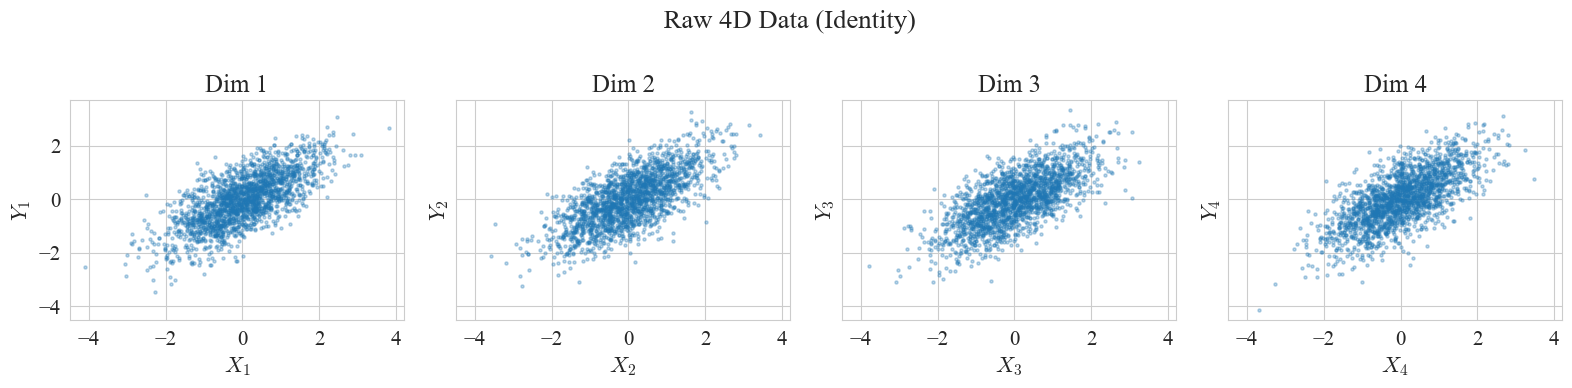

--- Running CCA Sweep ---


  0%|          | 0/4 [00:00<?, ?it/s]

--- Running Neural Sweep: Separable ---


  0%|          | 0/7 [00:00<?, ?it/s]

Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
--- Running Neural Sweep: Separable Aug ---


  0%|          | 0/7 [00:00<?, ?it/s]

Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5


In [3]:
# --- Configuration 1.1: Identity ---
latent_dim = 4
mi_per_dim = 0.5
total_mi = latent_dim * mi_per_dim

cfg_1 = {
    "latent": {
        "latent_dim": latent_dim, 
        "mi_bits": total_mi
    },
    "transform": {
        "mode": "identity", 
        "observe_dim_x": None, # We didn't change the dimensionality, so when the mapping is identity we use None.
        "observe_dim_y": None,
    }
}

kz_sweep_low_cca = [1, 2, 3, 4] # CCA can't exceed observation dim
kz_sweep_low_neural = [1, 2, 3, 4, 5, 6, 10]

# Visulaize the data: Shows 4 separate scatter plots with clear linear correlation
visualize_data_distribution(cfg_1, title=" Raw 4D Data (Identity)")

# # --- Run Experiments ---
res_cca_1 = run_cca_sweep(cfg_1, kz_sweep_low_cca)
res_sep_1 = run_neural_sweep("separable", "Separable", kz_sweep_low_neural, cfg_1)
res_aug_1 = run_neural_sweep("separable_augmented", "Separable Aug", kz_sweep_low_neural, cfg_1)

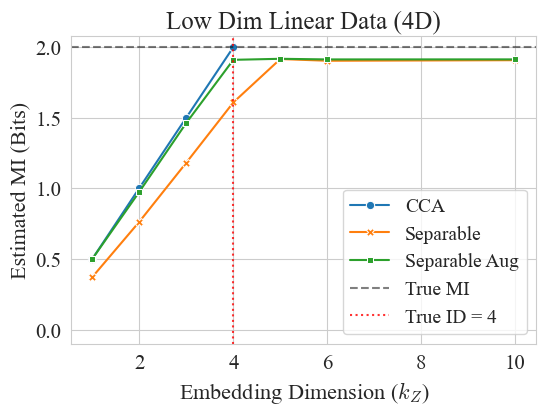

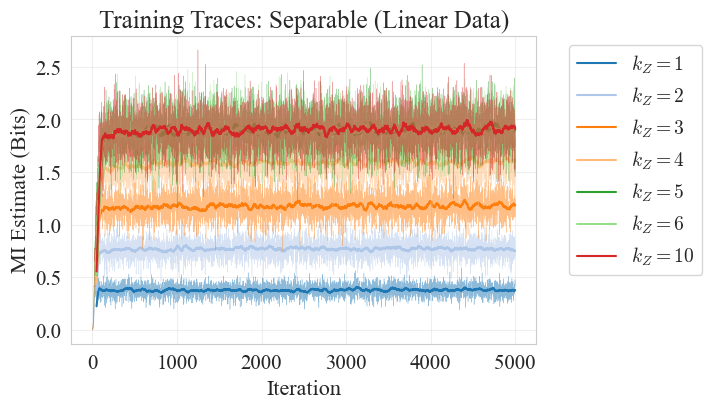

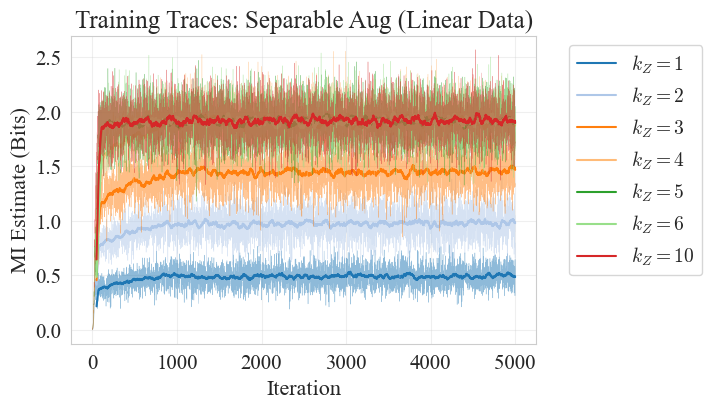

In [4]:
# --- Plot 1: Saturation Curves ---
plot_mi_saturation([res_cca_1, res_sep_1, res_aug_1], 
                   "Low Dim Linear Data (4D)", 
                   true_id=latent_dim, true_mi=total_mi)

# --- Plot 2: Training Traces ---
# Showing convergence speed for different kz
plot_training_traces(res_sep_1, "Separable (Linear Data)")
plot_training_traces(res_aug_1, "Separable Aug (Linear Data)")

**Observation:** 
* **Separable Augmented** hits the true MI exactly at $k_Z=ID=4$. We'll be using this now as it performs better than bare separable.

* **Separable** works well but needs $k_Z=5$ to capture the total MI.

* They're both within the vicinity of the CCA baseline.

* Note that the estimators saturate after a certain number of iterations, and there's no apparent overfitting.

**Conclusion (Part 1):** Mutual Information Saturation can work as a proxy of ID. In linear settings, both linear and nonlinear based estimates work, and separable augmented accurately captures MI at the right $k_Z$.

## Part 2: The High Dimensional Case

Now, let's make it harder. We take the same 4D latent data, but we project it into **500 dimensions** using a linear "Random Matrix" or a nonlinear "Teacher" network ($X_{obs} = MLP(X_{latent})$ and similarly for $Y$).

The intrinsic dimensionality is still 4. However, the data now lives on a linear or nonlinear manifold in 500D space.

### 2.1: The Linear Case:
**Hypothesis:**
1.  **CCA will continue to work:** It searches for linear correlations. Even if the apparent dimension is 500, as long as the data is transformed linearly, CCA should find it and saturate at the correct ID.
2.  **Neural Estimators will also succeed:** The Seprable Augmented Encoder ($f, g$) can learn to invert the linear matrix multiplication transform, recovering the 4D latents at exactly 4 (note that at low number of iterations, the estimator might have not saturated at the right information value yet).

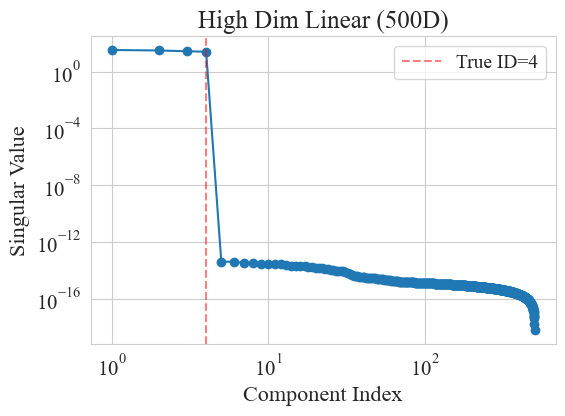

--- Running CCA Sweep ---


  0%|          | 0/10 [00:00<?, ?it/s]

--- Running Neural Sweep: Separable Aug ---


  0%|          | 0/10 [00:00<?, ?it/s]

Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5


In [11]:
# --- Configuration 2.1: High Dim Linear ---
cfg_2_1 = {
    "latent": {
        "latent_dim": latent_dim, 
        "mi_bits": total_mi
    },
    "transform": {
        "mode": "linear", # Random linear projection matrix
        "observe_dim_x": 500,
        "observe_dim_y": 500,
    }
}

# We can sweep kz higher now since observation is high-dim
kz_sweep_high = [1, 2, 3, 4, 5, 6, 10, 20, 50, 100]

# Visualize the singular value spectrum of the cross covariance matrix, it will show a SHARP DROP after component 4.
visualize_data_distribution(cfg_2_1, title="High Dim Linear (500D)")

# --- Run Experiments ---
res_cca_2_1 = run_cca_sweep(cfg_2_1, kz_sweep_high)
# res_sep_2_1 = run_neural_sweep("separable", "Separable", kz_sweep_high, cfg_2_1) # You can uncomment this to run Separable as well, but Separable Augmented is better.
res_aug_2_1 = run_neural_sweep("separable_augmented", "Separable Aug", kz_sweep_high, cfg_2_1)

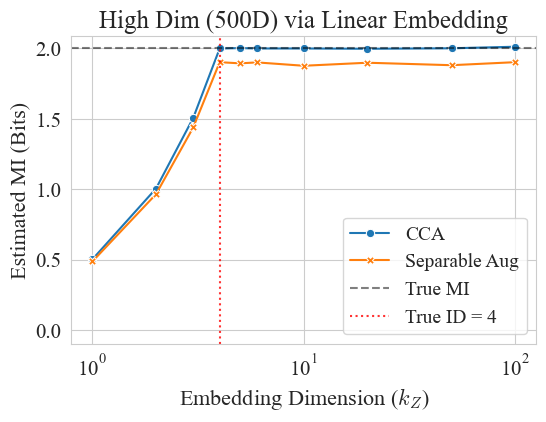

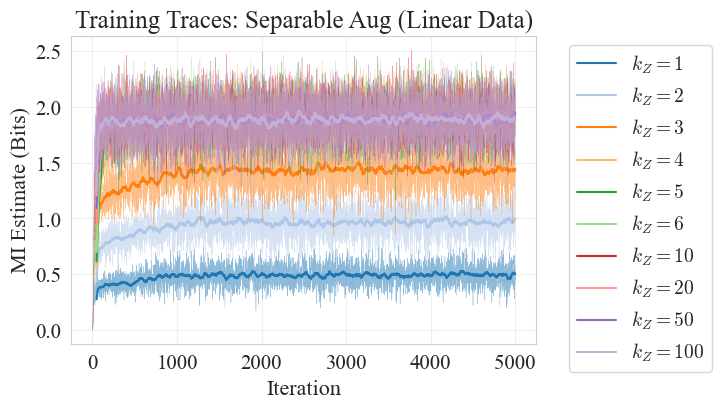

In [12]:
# --- Plot --- # Remember to add Separable (res_sep_2_1) if you ran it
plot_mi_saturation([res_cca_2_1, res_aug_2_1], 
                   "High Dim (500D) via Linear Embedding", 
                   true_id=latent_dim, true_mi=total_mi, log_scale=True)

# --- Plot 2: Training Traces ---
# Showing convergence speed for different kz
plot_training_traces(res_aug_2_1, "Separable Aug (Linear Data)")

**Observation:** 
* **CCA** works fine even in high dimensional setups, as long as the latents are transformed linearly.

* **Separable Augmented** also works, hits the true MI exactly at $k_Z=ID=4$. 

### 2.2: The NonLinear Case:
**Hypothesis:**
1.  **CCA will fail:** It searches for linear correlations. A nonlinear embedding creates many spurious linear correlations in 500D, causing CCA to overestimate MI and fail to saturate.

2.  **Neural Estimators will succeed:** The neural estimators are designed to learn nonlinear embeddings, they will learn to invert the nonlinear teacher transform (also note that the training might take larger number of iterations to saturate at the correct MI values).

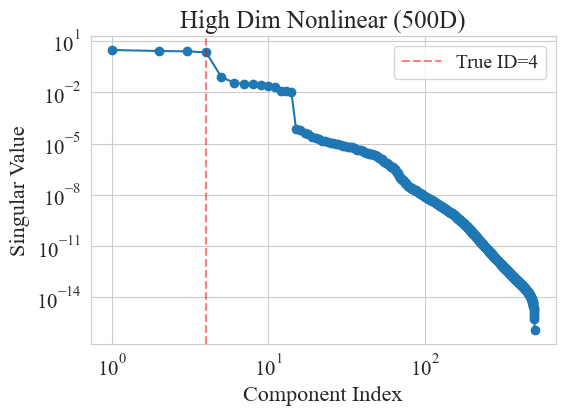

--- Running CCA Sweep ---


  0%|          | 0/10 [00:00<?, ?it/s]

--- Running Neural Sweep: Separable Aug ---


  0%|          | 0/10 [00:00<?, ?it/s]

Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5


In [13]:
# --- Configuration 2.2: High Dim Nonlinear ---
cfg_2_2 = {
    "latent": {
        "latent_dim": latent_dim, 
        "mi_bits": total_mi
    },
    "transform": {
        "mode": "teacher", # MLP projection
        "observe_dim_x": 500,
        "observe_dim_y": 500,
    }
}

# Visualize the singular value spectrum of the cross covariance matrix, it will show more relevant singular values even after the 4th component.
visualize_data_distribution(cfg_2_2, title="High Dim Nonlinear (500D)")

# --- Run Experiments ---
res_cca_2_2 = run_cca_sweep(cfg_2_2, kz_sweep_high)
# res_sep_2_2 = run_neural_sweep("separable", "Separable", kz_sweep_high, cfg_2_2) # You can uncomment this to run Separable as well, but Separable Augmented is better.
res_aug_2_2 = run_neural_sweep("separable_augmented", "Separable Aug", kz_sweep_high, cfg_2_2)

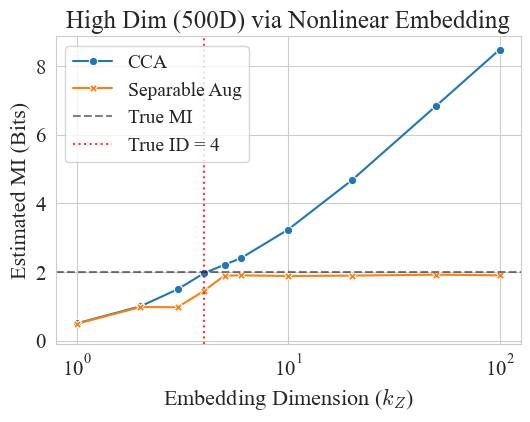

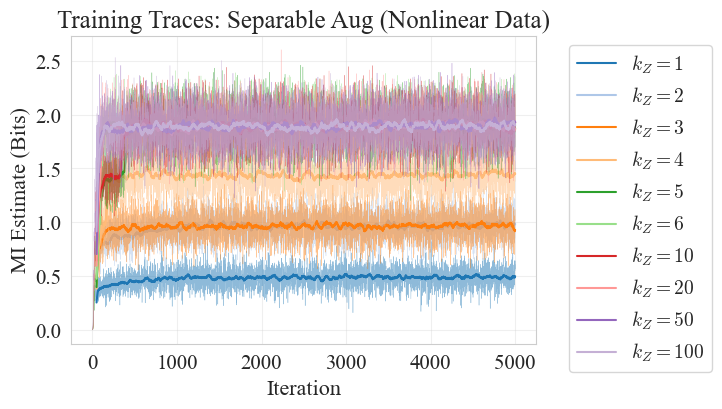

In [14]:
# --- Plot --- # Remember to add Separable (res_sep_2_2) if you ran it
plot_mi_saturation([res_cca_2_2, res_aug_2_2], 
                   "High Dim (500D) via Nonlinear Embedding", 
                   true_id=latent_dim, true_mi=total_mi, log_scale=True)

# --- Plot 2: Training Traces ---
# Showing convergence speed for different kz
plot_training_traces(res_aug_2_2, "Separable Aug (Nonlinear Data)")

**Observation:** 
* **CCA** doesn't saturate and keep increasing with more dimensions, as it's interpreting the different nonlinear parts of the embeddings as different new parts of the "linear information".

* **Separable Augmented** Works! hits the true MI exactly at $k_Z=ID=4$. Note that this is a harder training task, and it might need more iterations, and you can see some jumps in the MI traces, but it saturates. 

**Conclusion (Part 2):** The neural estimators recover the true ID (saturation at 4) and true MI (approx 2 bits), effectively ignoring the 496 dimensions of noise/nonlinearity. CCA drastically overestimates in the nonlinear cases.

## Part 3: The Hard Case (Gaussian Mixture)

Finally, we tackle a case where the geometry itself is challenging.
* **Dataset:** Gaussian Mixture ($X$ and $Y$ are correlated, but multimodal).
* **ID:** 1.
* **Complexity:** $N_p=8, \mu=8, \sigma=2$. 8 Modes, not all are well-separated.

**The Problem:** Separable critics use a dot product $f(x)^T g(y)$. This forces the relationship to be monotonic in the embedding space. Capturing a mixture (which looks like "If X is in Mode A, Y is in Mode A; if X is in Mode B, Y is in Mode B") is geometrically difficult for a dot product without adding extra dimensions to "unfold" the mixture.

**The Solution:** The **Hybrid Critic**. It concatenates the embeddings and passes them through an MLP ($MLP([f(x), g(y)])$), allowing it to learn arbitrary decision boundaries.

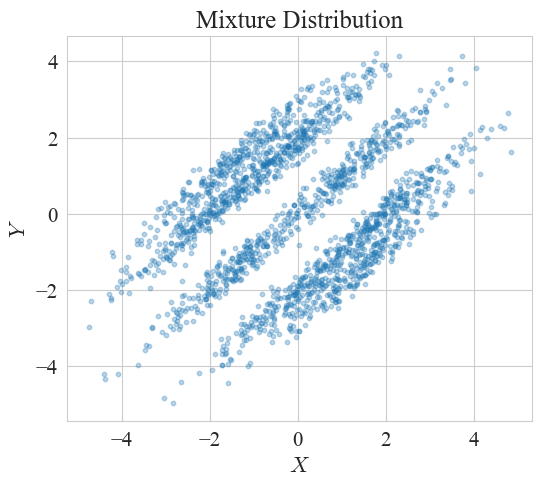

--- Running Neural Sweep: Separable Aug ---


  0%|          | 0/10 [00:00<?, ?it/s]

Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
--- Running Neural Sweep: Hybrid ---


  0%|          | 0/10 [00:00<?, ?it/s]

Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5
Using device: mps
Run completed; saved to temp.h5


In [9]:
# --- Configuration 3: Gaussian Mixture ---
# 1D Latent, 2 Peaks. Identity transform.
# ID = 1.
cfg_3 = {
    "latent": {
        "latent_dim": 1, 
        "n_peaks": 8,
        "mu": 2.0,      # Widely separated
        "sig": 1.0,
        "mi_bits_peak": 2.0 
    },
    "transform": {
        "mode": "identity", 
        "observe_dim_x": None,
        "observe_dim_y": None,
    }
}

kz_sweep_mix = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]

# Shows the 2D scatter plot with two distinct clusters.
visualize_data_distribution(cfg_3, dataset_type="gaussian_mixture", title="Mixture Distribution")

# --- Run Experiments ---
# Separable (Simple Dot Product)
# res_sep_3 = run_neural_sweep("separable", "Separable", kz_sweep_mix, cfg_3, "gaussian_mixture")

# Separable Aug (Quadratic Dot Product)
res_aug_3 = run_neural_sweep("separable_augmented", "Separable Aug", kz_sweep_mix, cfg_3, "gaussian_mixture")

# Hybrid (MLP Concatenation - The General Solution)
res_hybrid_3 = run_neural_sweep("hybrid", "Hybrid", kz_sweep_mix, cfg_3, "gaussian_mixture")

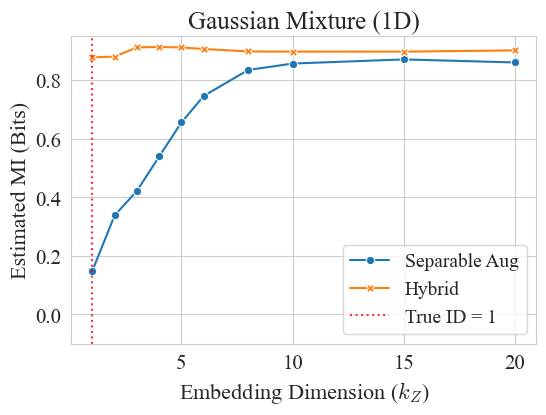

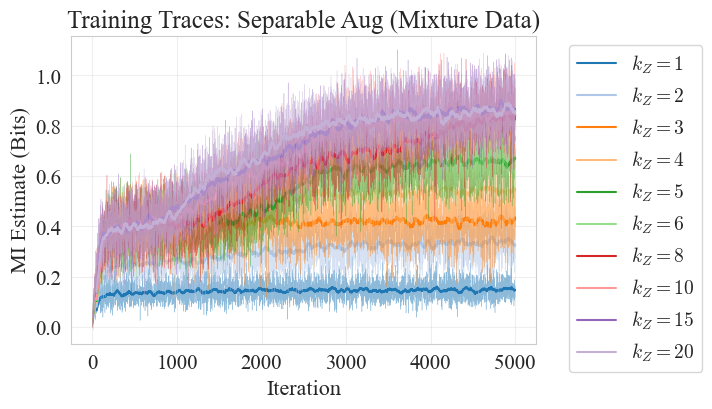

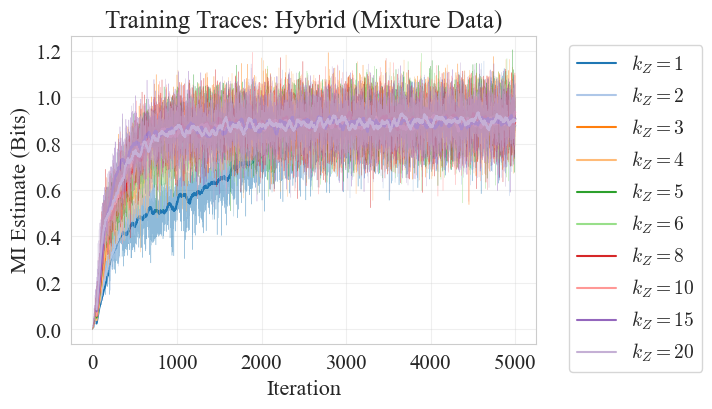

In [10]:
# --- Plot --- # Remember to add Separable (res_sep_3) if you ran it
# Note: True MI for mixture is unknown analytically. We can only mark the true ID=1. We can estimate MI via a concat critic, but it's not exact and beyond this tutorial's scope.
plot_mi_saturation([res_aug_3, res_hybrid_3], 
                   "Gaussian Mixture (1D)", 
                   true_id=1, true_mi=None)

# --- Plot 2: Training Traces ---
# Showing convergence speed for different kz
plot_training_traces(res_aug_3, "Separable Aug (Mixture Data)")
plot_training_traces(res_hybrid_3, "Hybrid (Mixture Data)")

**Observation:** 
* **Separable Augmented** likely shows a "slow rise." Even though ID=1, it might keep gaining MI at $k_z=2$ or $3$. This is **False ID estimation**; the model is using extra dimensions just to fix its own lack of capacity.

*  **Hybrid** starts immediately to the max value at $k_z=1$ and stay flat. This confirms that the data truly only has 1 dimension of shared information, and the critic had enough capacity to see it.

**Conclusion (Part 3):** The choice of critic architecture influnces the saturation point of MI. The **Hybrid Critic** should be used as a better way of estimating MI and it's able to capture it with the correct number of dimensions, giving the ID as an additional result. 

## Takeaway:
We have shown that MI sturation curves as a function of number of embedding dimensions $k_Z$ is a good signal of the intrinsic dimensionality of the data. For complex, multimodal, or "hard" geometry, our new **Hybrid Critic** provides the most reliable estimate of Intrinsic Dimensionality.